# Endometrium analysis - clusters visualization

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_stromal/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.4 anndata==0.6.22rc1 umap==0.3.10 numpy==1.17.5 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

## Load data

In [2]:
adata = sc.read('data/stromal.h5ad')
adata.X.shape

(22004, 3719)

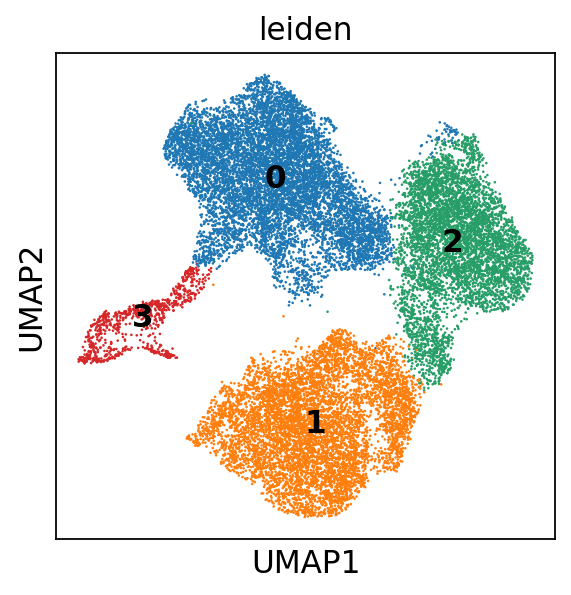

In [3]:
sc.pl.umap(adata, color=['leiden'], legend_loc="on data")

## Rename clusters

In [4]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3'], dtype='object')

... storing 'clusters' as categorical


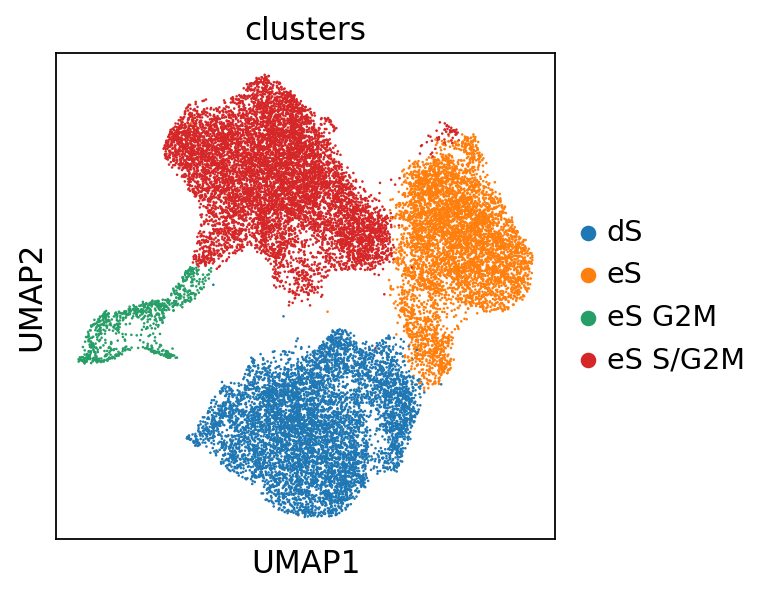

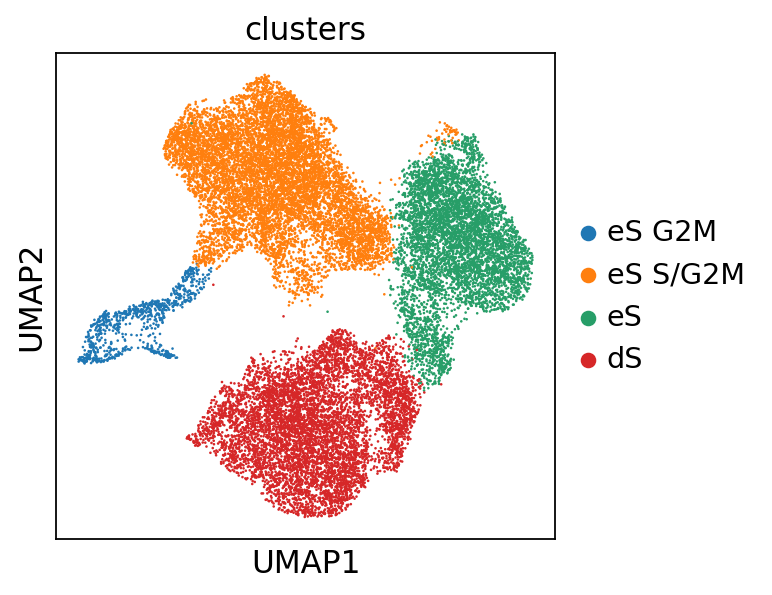

In [5]:
adata.obs['clusters'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['clusters'] == '0', 'clusters'] = 'eS S/G2M'
adata.obs.at[adata.obs['clusters'] == '1', 'clusters'] = 'dS'
adata.obs.at[adata.obs['clusters'] == '2', 'clusters'] = 'eS'
adata.obs.at[adata.obs['clusters'] == '3', 'clusters'] = 'eS G2M'
set(adata.obs['clusters'])
sc.pl.umap(adata, color=['clusters'])
# order 1 > 0 > 2 > 9 > 8 > 5 > 4 > 3 > 6
adata.obs['clusters'].cat.reorder_categories(['eS G2M', 'eS S/G2M', 'eS', 'dS'], inplace=True)
sc.pl.umap(adata, color=['clusters'])

## Change colors and plot UMAP

Choose the colors of the clusters a bit more consistently.

In [ ]:
import matplotlib.pyplot as pl

for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()
orig_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = orig_colors.copy()
new_colors

In [ ]:
new_colors[[0, 1, 2, 3]] = ["#675536", "#A0815C", "#C2B59B", "#E0C391"]
adata.uns['clusters_colors'] = new_colors
sc.pl.umap(adata, color=['clusters'], save='_figure1x_stromal.pdf')

## Save Stats

In [ ]:
stats = adata.obs.clusters.values.describe()
stats.to_csv(str(sc.settings.figdir)+'/cluster_stats.csv')
adata.obs.to_csv(str(sc.settings.figdir)+'/barcode_metadata.csv')

## Generate matrix and save cellXgene

In [ ]:
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
# sc.pp.scale(adata_count, max_value=10)
adata_count.obsm['X_umap'] = adata.obsm['X_umap']
adata_count.uns['clusters_colors'] = adata.uns['clusters_colors']
adata_count.write('cellXgene/endometrium_stromal.h5ad')

## Dotplot with markers

In [ ]:
with open('data/markers/Markers_stromal.csv','r') as fid:
    markers = [line.rstrip() for line in fid.readlines()]

print(len(markers))
#make sure they're in the dataset, and sort them alphabetically for ease of finding things
no_markers = [item for item in markers if item not in adata_count.var_names]
markers = [item for item in markers if item in adata_count.var_names]
print(len(markers))

sc.pl.dotplot(adata_count, markers, groupby='clusters', dendrogram=False, save='_Figure1I_stromal_RoserMarkers.pdf')

## UMAP with markers

In [16]:
# markers = ['PGR', 'IHH', 'IGFBP4', 'GCLC', 'EMID1', 'CPM',
#                              'MKI67','HMGB2', "NOTCH3",
#                                   'LGR5','WNT7A', 'VTCN1', 'SLC26A7', 'CLDN22', 'PDPN', 'KRT5',
#                                  'LGR6', 'PNMT', 'TRH', 'PPP1R1B', 'ALDH1A1', 'WIF1',
#                                  'SEMA3B','FHL2', 'LIF', 'CCL2', 'ICAM1', 'CXCL2',
#                                  'MMP7', 'IFI6', 'RBP1', 'LYPD1', 'PAEP',
#                              'PTGS1', 'MT1G','ENPP3', 'SLC26A2',
#                                'C10orf10','NOTCH2', 'SCGB2A1', 'PDK4', 'ANG', 'C4BPA',
#                             'CXCL14','PAEP', 'RIMKLB', 'NUPR1','TFF3', 'MUC5B', 
#                             'LTF', 'BPIFB1', 'LHX1', 'PIFO', 'FOXJ1', 'TPPP3']
# sc.pl.umap(adata, color=markers, save='_markers_primary_epithelial_fromDotplot.pdf',color_map='OrRd', use_raw=True) # FEMALE

## DEGs

### All vs rest

#### scanpy

In [33]:
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
sc.pp.scale(adata_count, max_value=10)
# marker calling
sc.tl.rank_genes_groups(adata, groupby='leiden', n_genes=50000, use_raw=False) #, method='logreg'

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


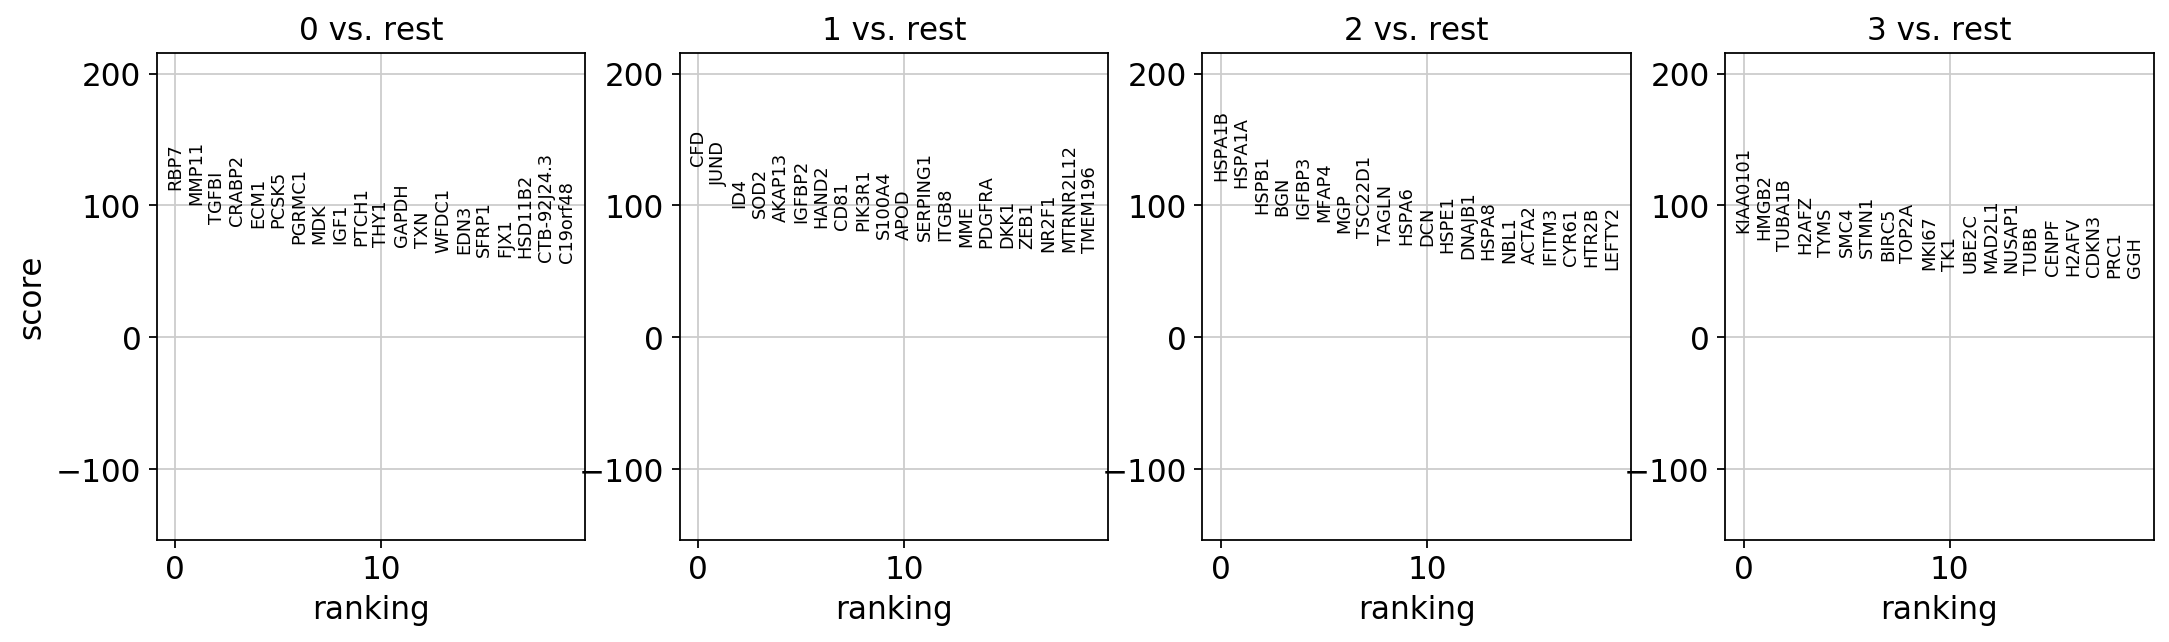

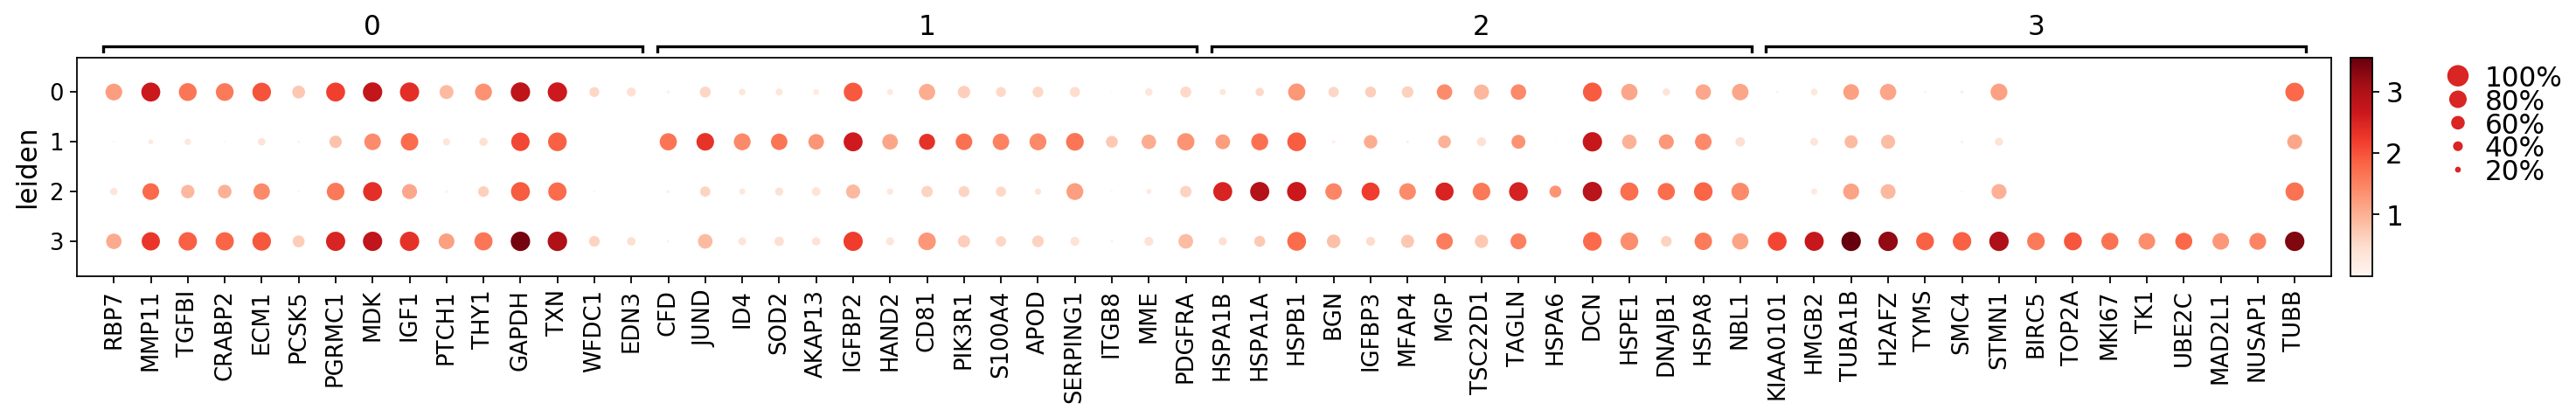

In [34]:
#marker visualisation
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, save='.pdf')

In [35]:
result = adata.uns['rank_genes_groups']
os.system('mkdir -p '+str(sc.settings.figdir)+'/cluster_markers/')
os.system('rm '+str(sc.settings.figdir)+'/cluster_markers/*scanpy*.csv')

for group in result['names'].dtype.names:
    print(group)
    adata_clus = adata_count[adata_count.obs['leiden'] == group]
    adata_rest = adata_count[[not i for i in adata_count.obs['leiden']==group]]
    mask = (result['pvals_adj'][group]<=1) & (result['scores'][group]>0)
    markdict = {'gene_'+key: result[key][group][mask] for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']}
    adata_clus = adata_clus[:,markdict['gene_names']]
    adata_rest = adata_rest[:,markdict['gene_names']]
    markdict['mean_cluster'] = np.asarray(np.mean(adata_clus.X,axis=0)).reshape(-1)
    markdict['mean_rest'] = np.asarray(np.mean(adata_rest.X,axis=0)).reshape(-1)
    markdict['log2_FC'] = np.asarray(np.log2(markdict['mean_cluster']/markdict['mean_rest'])).reshape(-1)
    #are you expressed?
    adata_clus.X = adata_clus.X > 0
    adata_rest.X = adata_rest.X > 0
    markdict['percent_cluster'] = np.asarray(100*np.sum(adata_clus.X,axis=0)/adata_clus.shape[0]).reshape(-1)
    markdict['percent_rest'] = np.asarray(100*np.sum(adata_rest.X,axis=0)/adata_rest.shape[0]).reshape(-1)
    df = pd.DataFrame(markdict)
    df.rename(columns={'gene_names':'Gene',
                       'gene_logfoldchanges':'logFC',
                       'log2_FC':'log2_FC',
                       'gene_pvals':'P.Value',
                       'gene_pvals_adj':'adj.P.Val',
                       'mean_cluster':'mean_cluster',
                       'mean_rest':'mean_rest'},
              inplace=True)
    df.to_csv(str(sc.settings.figdir)+'/cluster_markers/'+group+'_scanpy_DEGs.csv')

0


/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log2
  from ipykernel import kernelapp as app
Trying to set attribute `.X` of view, making a copy.
Trying to set attribute `.X` of view, making a copy.


1


Trying to set attribute `.X` of view, making a copy.
Trying to set attribute `.X` of view, making a copy.


2


Trying to set attribute `.X` of view, making a copy.
Trying to set attribute `.X` of view, making a copy.


3


Trying to set attribute `.X` of view, making a copy.
Trying to set attribute `.X` of view, making a copy.


#### DE with limma

Prepare object to run limma

In [36]:
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.filter_genes(adata_count, min_cells=3)
sc.pp.filter_cells(adata_count, min_genes=200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.X.shape)

(22004, 21918)


In [37]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [38]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['leiden']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AAACCTGCACCTCGGA,2,A10,CBTM
1,4861STDY7309368_AAACCTGTCTAACGGT,2,A10,CBTM
2,4861STDY7309368_AAACGGGAGCTCCTTC,2,A10,CBTM
3,4861STDY7309368_AAACGGGCATCACGAT,2,A10,CBTM
4,4861STDY7309368_AAAGCAATCAAACCGT,2,A10,CBTM


In [39]:
outpath = str(sc.settings.figdir)+'/cluster_markers/'

In [40]:
%load_ext rpy2.ipython

In [ ]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell


# Shared cells
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate


# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in celltypes){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    design.matrix <- model.matrix(~ 0 + cluster_type)
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$Gene = rownames(results)
    results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    # and store it as csv file
    write.csv(results, file = paste0(outpath, celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AAACCTGCACCTCGGA" "4861STDY7309368_AAACCTGTCTAACGGT"
[3] "4861STDY7309368_AAACGGGAGCTCCTTC"
[1] "4861STDY7309368_AAACCTGCACCTCGGA" "4861STDY7309368_AAACCTGTCTAACGGT"
[3] "4861STDY7309368_AAACGGGAGCTCCTTC"


R[write to console]: 22004 shared cells

R[write to console]: 2

R[write to console]: Cells in cluster 5381
Cells in rest 16623

R[write to console]: 0

R[write to console]: Cells in cluster 8912
Cells in rest 13092

R[write to console]: 1

R[write to console]: Cells in cluster 6906
Cells in rest 15098

R[write to console]: 3

R[write to console]: Cells in cluster 805
Cells in rest 21199



### rbcde

In [ ]:
import rbcde
rbcde.RBC(adata_count, use_raw=False, cl)

In [41]:
degs, plot_dict = rbcde.filter_markers(adata_count, use_raw=False, thresh=0.5)
set(degs.cluster.values)

{'0', '1', '2', '3'}

0


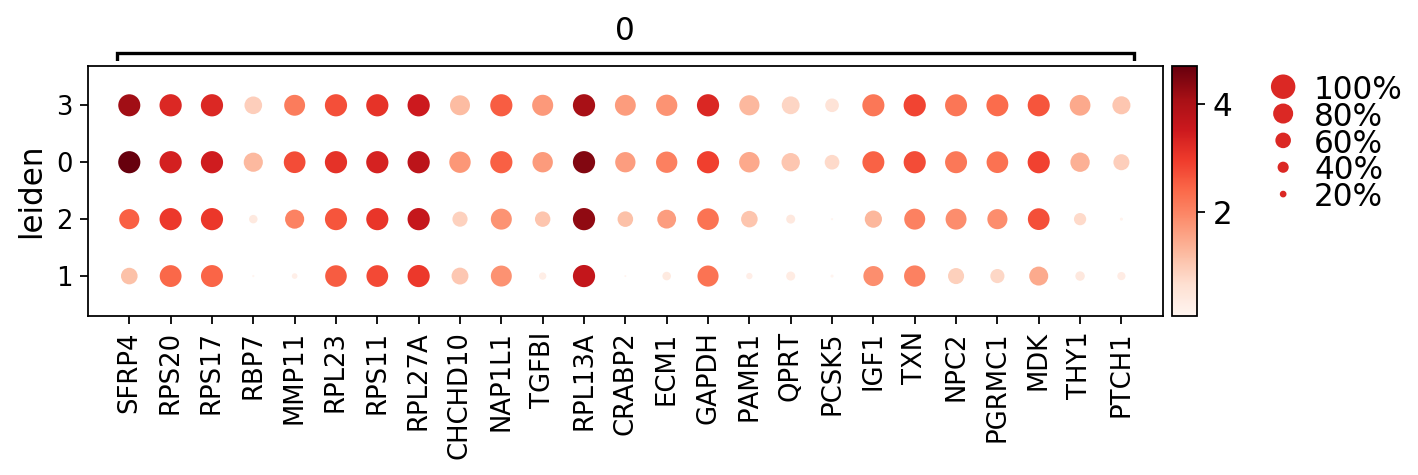

2


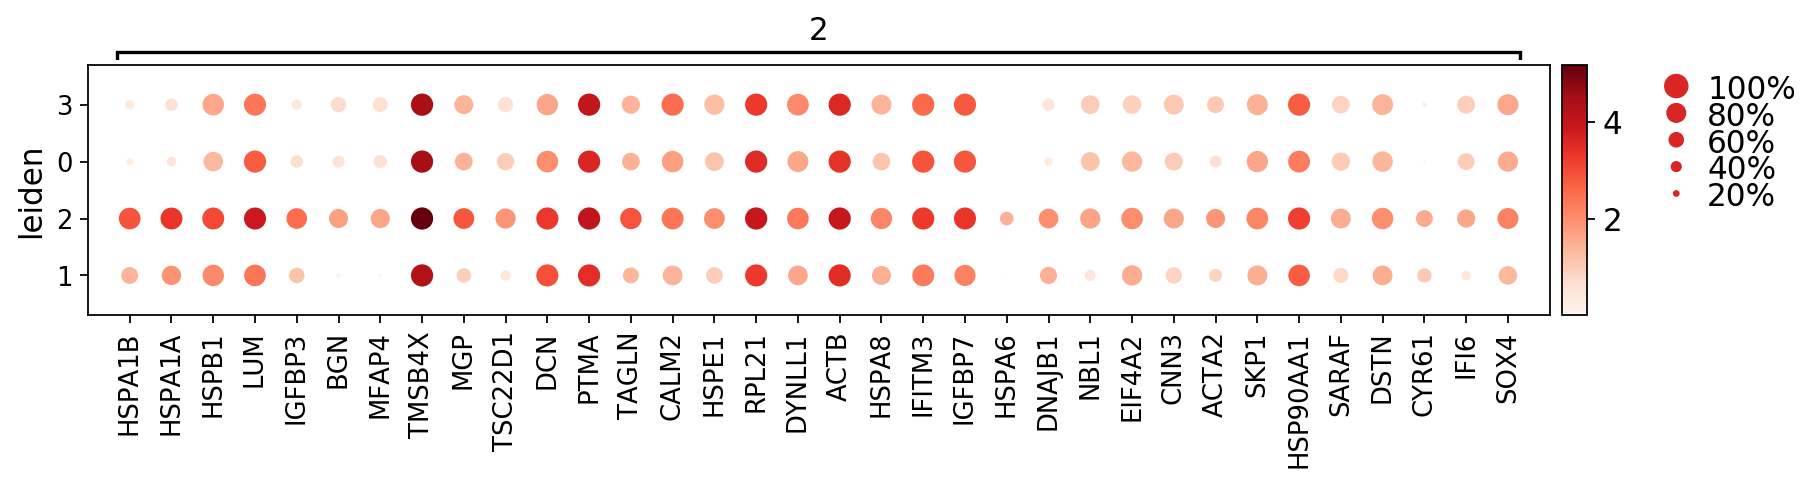

1


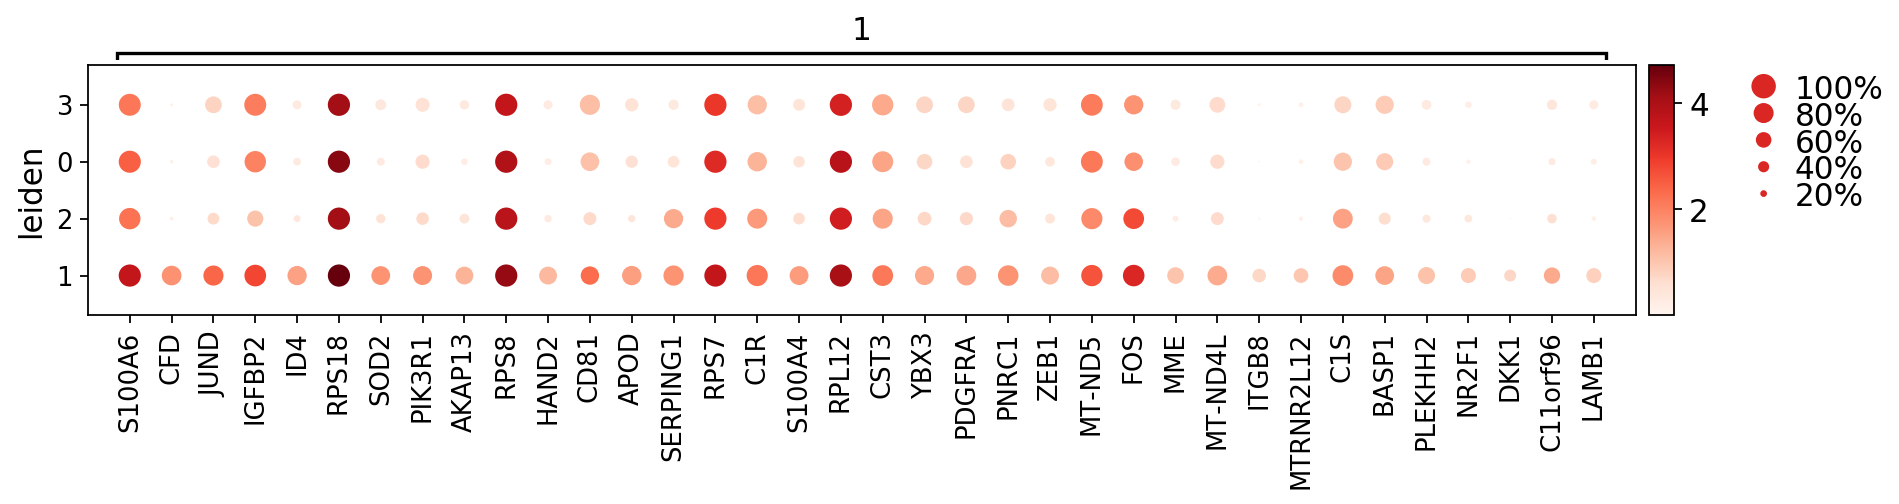

3


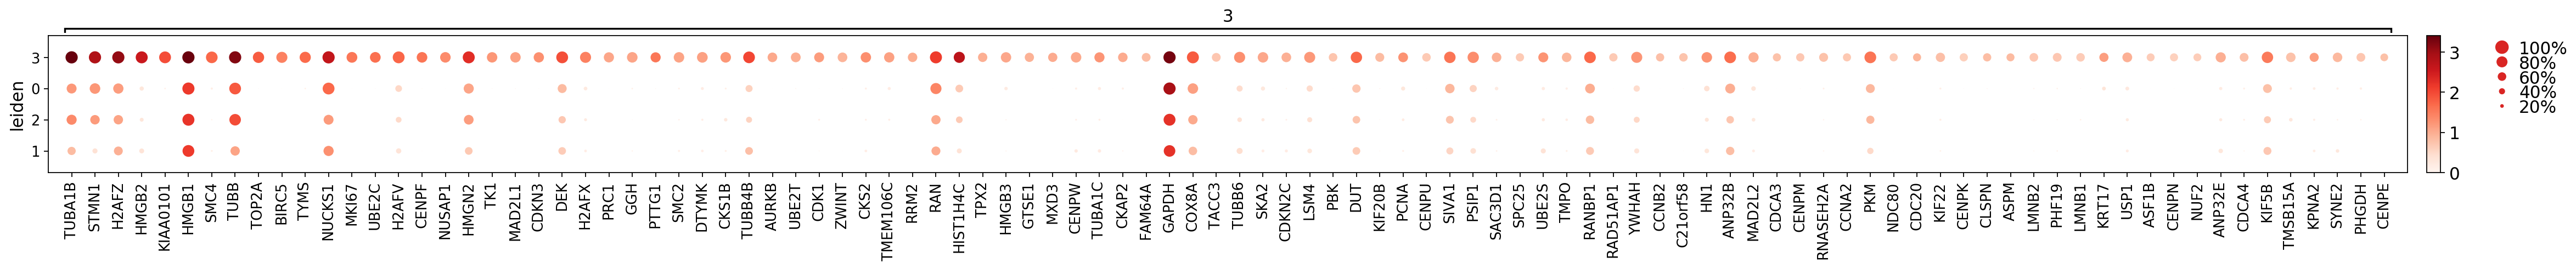

In [42]:
for clus in set(degs.cluster.values):
    print(clus)
    sc.pl.dotplot(adata_count, {clus: plot_dict[clus][:100]}, groupby='leiden', use_raw=False, save='_cluster_markers_'+clus+'.pdf')
